In [49]:
# Dependencies
import tensorflow as tf # Tensorflow 1.2
import pandas as pd
import keras as k
from keras.layers import  LSTM,Input,Dense
from keras.layers import BatchNormalization as BN
from keras.models import Model
from sklearn.metrics import mean_squared_error
from keras import losses
from math import sqrt


In [111]:
# Data Preprocessing

df=pd.read_csv('diesel.csv')
df.set_index('Date',inplace=True)
df.head()


,Delhi,Foreign Exchange Rate,Crude Oil Price
Date,,,
01-01-2003,19.47,48.01,29.59
02-01-2003,19.47,48.05,29.59
03-01-2003,19.07,48.00,29.59
04-01-2003,19.07,48.00,29.59
05-01-2003,19.07,48.00,29.59


In [3]:
data=df.drop(['Delhi','Crude Oil Price'],axis=1)

In [4]:
#Make Sequences by shifting the Foreign Exchange Rate by 1 unit.
Inputs=data['Foreign Exchange Rate'].shift(1,fill_value=0)
data.loc[:,'Inputs']=Inputs
data.rename(columns={'Foreign Exchange Rate':'Outputs'},inplace=True)
data.head()


,Outputs,Inputs
Date,,
01-01-2003,48.01,0.00
02-01-2003,48.05,48.01
03-01-2003,48.00,48.05
04-01-2003,48.00,48.00
05-01-2003,48.00,48.00


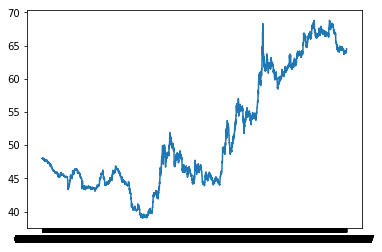

In [113]:
# Data Plotting
from matplotlib import pyplot as plt
plt.plot(data.iloc[:,0])


In [43]:
X=[]
Y=[]
import numpy as np
for i in range(int((len(data)-90)/5)):
    slice_x=data.iloc[5*i:(5*i+90),1]
    X.append(list(slice_x))
    slice_y=[(data.iloc[5*i+90,0])]
    Y.append(slice_y)
    
X=np.array(X)
Y=np.array(Y)
#Reshaping to (samples,timesteps,features)
X=np.reshape(X,(1057,90,1))
Y=np.reshape(Y,(1057,1))    

print(X.shape,Y.shape)





    

(1057, 90, 1) (1057, 1)


In [85]:
''' Model building phase 
Using Keras (tensorflow backend), Functional API
1. Creating LSTM with 50 neurons, 4 hidden layers.'''

inputs=Input(shape=(90,1))
x=BN(axis=-1)(inputs)
# Adding LSTM
x=LSTM(units=50,activation='tanh',recurrent_activation='hard_sigmoid',use_bias=True,recurrent_initializer='he_normal',name='piku',kernel_initializer='lecun_normal',return_sequences=True)(inputs)
x=LSTM(units=50,activation='tanh',recurrent_activation='hard_sigmoid',use_bias=True,recurrent_initializer='he_normal',kernel_initializer='lecun_normal',return_sequences=True)(x)
x=LSTM(units=50,activation='tanh',recurrent_activation='hard_sigmoid',use_bias=True,recurrent_initializer='he_normal',kernel_initializer='lecun_normal',return_sequences=True)(x)
x=LSTM(units=50,activation='tanh',recurrent_activation='hard_sigmoid',use_bias=True,recurrent_initializer='he_normal',kernel_initializer='lecun_normal',return_sequences=False)(x)
x=Dense(10,activation='relu')(x)
# Output layer
prediction=Dense(1,activation=None)(x)
model=Model(inputs=inputs,outputs=prediction)


       
''' Use of recurrent_initializer: For tanh-use lecun_normal[1]
 Use of kernel_initializer: For Sigmoid use: he_normal[2]
[1] Klambauer, G., Unterthiner, T., Mayr, A., & Hochreiter, S. (2017). Self-normalizing neural networks. In Advances in neural information processing systems (pp. 971-980).
[2] [He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving deep into rectifiers: Surpassing human-level performance on imagenet classification. In Proceedings of the IEEE international conference on computer vision (pp. 1026-1034).]'''

' Use of recurrent_initializer: For tanh-use lecun_normal[1]\n Use of kernel_initializer: For Sigmoid use: he_normal[2]\n[1] Klambauer, G., Unterthiner, T., Mayr, A., & Hochreiter, S. (2017). Self-normalizing neural networks. In Advances in neural information processing systems (pp. 971-980).\n[2] [He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving deep into rectifiers: Surpassing human-level performance on imagenet classification. In Proceedings of the IEEE international conference on computer vision (pp. 1026-1034).]'

In [88]:
# Compilation and training
#Using Root Mean square error
import keras.backend as K
def rmse(y_true,y_pred):
    loss=K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))
    return loss
model.compile(optimizer='adam',loss=rmse,metrics=['accuracy'])
hist=model.fit(x=X,y=Y,batch_size=100,epochs=10,validation_split=0.1)

Train on 951 samples, validate on 106 samples
Epoch 1/10
951/951 [==============================] - 29s 31ms/step - loss: 20.6807 - acc: 0.0000e+00 - val_loss: 18.4800 - val_acc: 0.0000e+00
Epoch 2/10
951/951 [==============================] - 16s 17ms/step - loss: 6.0565 - acc: 0.0000e+00 - val_loss: 18.5273 - val_acc: 0.0000e+00
Epoch 3/10
951/951 [==============================] - 16s 17ms/step - loss: 5.9651 - acc: 0.0000e+00 - val_loss: 19.7891 - val_acc: 0.0000e+00
Epoch 4/10
951/951 [==============================] - 14s 15ms/step - loss: 5.8958 - acc: 0.0011 - val_loss: 19.9856 - val_acc: 0.0000e+00
Epoch 5/10
951/951 [==============================] - 16s 17ms/step - loss: 5.8629 - acc: 0.0011 - val_loss: 19.6158 - val_acc: 0.0000e+00
Epoch 6/10
951/951 [==============================] - 16s 16ms/step - loss: 5.8545 - acc: 0.0000e+00 - val_loss: 19.9308 - val_acc: 0.0000e+00
Epoch 7/10
951/951 [==============================] - 16s 17ms/step - loss: 5.8291 - acc: 0.0011 - val_

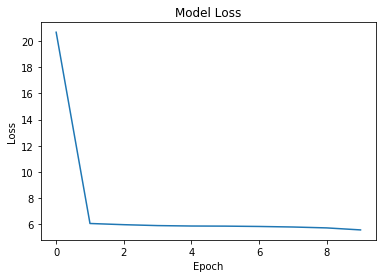

In [109]:
# Plotting loss
from matplotlib import pyplot as plt
plt.plot(hist.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [94]:
#Prediction
Actual=[]
Prediction=[]
for i in range(20):
    
    Actual.append(data.iloc[i*90+90,0])
    
    Prediction.append(model.predict(np.resize(data.iloc[i*90:i*90+90,1],(1,90,1))))
    

In [95]:
Actual

[47.46,
 46.44,
 45.84,
 45.53,
 44.7,
 45.67,
 45.79,
 43.86,
 43.61,
 43.53,
 43.81,
 45.3,
 44.13,
 45.81,
 46.17,
 44.52,
 44.17,
 40.48,
 40.53,
 39.22]

In [105]:
Prediction=np.reshape(Prediction,(20,1)) # As output from predict is an array of shape (20,)
plt.plot()

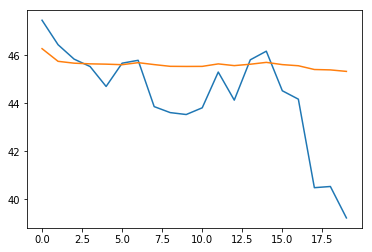

In [106]:
# Visualization of results: actual vs predicted

plt.plot(Actual)
plt.plot(Prediction)
plt.xlabel()
plt.show()

In [ ]:
# Possible Issues:
# 1.Overfitting of model
# 2. High

# To Do: 
#1. Change learning Rate
#2. Change number of epochs abd batch_size
#3. Batch Normalize after each layer.
#4. Change distribution of data and data augmentation.